# Equivalent Layer with positivity: convergence analysis

#### Importing libraries

In [1]:
% matplotlib inline 

In [2]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import cPickle as pickle
import datetime
import timeit
from scipy.optimize import nnls
from fatiando.gridder import regular
from fatiando.utils import ang2vec, vec2ang
from fatiando.mesher import Sphere, PointGrid,Prism
from fatiando.gravmag import sphere,prism
from fatiando.constants import CM, T2NT, G, SI2MGAL

/home/andrelreis/anaconda2/lib/python2.7/site-packages/fatiando/vis/mpl.py:76: UserWarning: This module will be removed in v0.6. We recommend the use of matplotlib.pyplot module directly. Some of the fatiando specific functions will remain.
  "specific functions will remain.")


In [3]:
notebook_name = 'regular_EQL_convergence.ipynb'

### Gray background figures

In [4]:
plt.style.use('grayscale')

#### Importing auxiliary functions

In [5]:
dir_modules = '../'
sys.path.append(dir_modules)

In [6]:
import eql_functions as func

In [7]:
import auxiliary_functions as fc

#### Loading properties of the model

In [8]:
with open('data/model_sphere_remanent.pickle') as f:
        model_sphere_remanent = pickle.load(f)

#### Loading properties grid

In [9]:
with open('data/airborne_survey.pickle') as f:
        airborne = pickle.load(f)

#### Loading data

In [10]:
with open('data/data_set.pickle') as f:
        data = pickle.load(f)

### Saving files

In [11]:
saved_files = []

## Observation area

In [12]:
print 'Area limits: \n x_max = %.1f m \n x_min = %.1f m \n y_max = %.1f m \n y_min = %.1f m' % (airborne['area'][1], 
                                                                                                airborne['area'][0],
                                                                                                airborne['area'][3],
                                                                                                airborne['area'][2])

Area limits: 
 x_max = 5000.0 m 
 x_min = -5000.0 m 
 y_max = 5000.0 m 
 y_min = -5000.0 m


### Airborne survey information

In [13]:
print 'Shape : (%.0f,%.0f)'% airborne['shape'] 
print 'Number of data: %.1f' % airborne['N']
print 'dx: %.1f m' % airborne['dx']
print 'dy: %.1f m ' % airborne['dy']

Shape : (50,20)
Number of data: 1000.0
dx: 204.1 m
dy: 526.3 m 


## Properties of the model

### Dimension and coordinate of the center

In [14]:
print 'Properties Sphere:\n xc = %.1f m \n yc = %.1f m \n zc = %.1f m \n radius = %.1f m ' %  (model_sphere_remanent['xc'],
                                                                                               model_sphere_remanent['yc'],
                                                                                               model_sphere_remanent['zc'],
                                                                                               model_sphere_remanent['radius'])

Properties Sphere:
 xc = 0.0 m 
 yc = 0.0 m 
 zc = 2000.0 m 
 radius = 1500.0 m 


### Main field

In [15]:
inc_gf,dec_gf = model_sphere_remanent['main_field']

In [16]:
print'Main field inclination: %.1f degree' % inc_gf
print'Main field declination: %.1f degree' % dec_gf

Main field inclination: 40.0 degree
Main field declination: 45.0 degree


### Magnetization direction

In [17]:
print 'Intensity: %.1f A/m' % model_sphere_remanent['m_R']
print 'Inclination: %.1f degree' % model_sphere_remanent['inc_R']
print 'Declination: %.1f degree' % model_sphere_remanent['dec_R']

Intensity: 15.0 A/m
Inclination: 60.0 degree
Declination: 10.0 degree


In [18]:
inc_R,dec_R = model_sphere_remanent['inc_R'],model_sphere_remanent['dec_R']

## Generating a layer

In [19]:
h = 1900.

In [20]:
shape_layer = (50,20)

In [21]:
xs,ys,zs = regular(airborne['area'],shape_layer,h)

## Data misfit analysis for different inc's and dec's

In [22]:
N_inc = 10

In [23]:
incs = np.linspace(-90.,90.,num=N_inc)

In [24]:
N_dec = 10

In [25]:
decs = np.linspace(0.,180.,num=N_dec)

In [26]:
Incs, Decs = np.meshgrid(incs,decs)

In [27]:
phi = []
p_est = []
for i,d in zip(Incs.ravel(),Decs.ravel()):
    G = fc.sensitivity_mag(airborne['x'],airborne['y'],airborne['z'],
                       xs,ys,zs,inc_gf,dec_gf,i,d)
    m,_ = nnls(G,data['tfa_obs_sphere_RM_airb'])
    tf_pred = fc.tfa_layer(airborne['x'],airborne['y'],airborne['z'],
                           xs,ys,zs,inc_gf,dec_gf,m,i,d)
    r = data['tfa_obs_sphere_RM_airb'] - tf_pred
    misfit = np.sum(r*r)
    phi.append(misfit)
    p_est.append(m)
    
    

In [28]:
phi = (np.array(phi)/airborne['x'].size).reshape(N_inc,N_dec)

### Data misfit map

/home/andrelreis/anaconda2/lib/python2.7/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


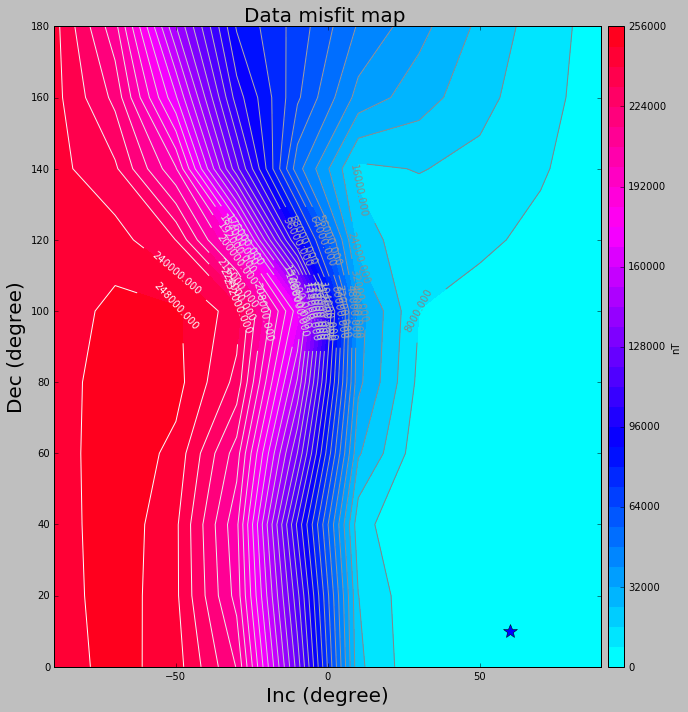

In [29]:
title_font = 20
bottom_font = 16
saturation_factor = 1.
plt.close('all')
plt.figure(figsize=(10,10), tight_layout=True)

ranges = saturation_factor*np.abs([phi.max(), phi.min()]).max()

plt.contourf(Incs,Decs,phi,40, cmap='hsv',vmin=-ranges, vmax=ranges)
plt.colorbar(pad=0.01, aspect=40, shrink=1.0).set_label('nT')
levels = plt.contour(Incs,Decs,phi,40,linecolor='b',vmin=-ranges, vmax=ranges)
plt.clabel(levels, inline=1, fontsize=10)
plt.plot(inc_R,dec_R,'b*',markersize=15)
#plt.plot(i_est,d_est,'w.',markersize=15)
plt.xlabel('Inc (degree)', fontsize = title_font)
plt.ylabel('Dec (degree)', fontsize = title_font)
plt.title('Data misfit map ', fontsize=title_font)

file_name = 'figs/airborne/noisy_data_misfit_-90_90'
plt.savefig(file_name+'.png',dpi=200)
saved_files.append(file_name+'.png')

plt.show()